<center> <h1>EnerjiSA Datathon</h1> </center>
<img src="https://upload.wikimedia.org/wikipedia/commons/b/b8/Photovoltaik_Dachanlage_Hannover_-_Schwarze_Heide_-_1_MW.jpg" style="margin: 0 auto; width: 100%; max-width: 950px; max-height: 300px" frameborder="0" scrolling="auto"/>

<a id="Import Libraries"></a>
<center> <h1>Import Libraries</h1> </center>

In [1]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
pd.set_option('display.float_format', lambda x: '%.8f' % x)

<a id="Data Preprocessing"></a>
<center> <h1>Data Preprocessing</h1> </center>


In [2]:
# read csv files
gen = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/generation.csv', delimiter=';')
temp = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/temperature.csv', delimiter=';')

In [3]:
# slicing frames due to deficiencies in data
df = pd.concat([gen.iloc[:25560], temp.iloc[:25560].drop('DateTime', axis=1)], axis=1)

In [4]:
object_cols = ['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed', 'EffectiveCloudCover', 'Generation']
for col in object_cols:
    df[col] = df[col].apply(lambda x: float(x.replace(',', '.')))
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')
df['WWCode'] = df['WWCode'].fillna(0).astype(int)
# Weather codes filled with "0" because this category means "Cloud development not observed or not observable" reference: https://www.jodc.go.jp/data_format/weather-code.html

In [5]:
test = temp.iloc[25560:26304] # dates between 2021-12-1 and 2021-12-31
for col in object_cols[:5]:
    test[col] = test[col].apply(lambda x: float(x.replace(',', '.')))
test['DateTime'] = pd.to_datetime(test['DateTime'])
test = test.set_index('DateTime')
test['WWCode'] = test['WWCode'].fillna(0).astype(int) # Weather code filled with "0" again
test.loc[test['WWCode'] == 84, 'WWCode'] = 83 
# category 84 samples changed to 83 because category 84 is not found in train set and 83 is the nearest category to 84

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<a id="Exploratory Data Analysis"></a>
<center> <h1>Exploratory Data Analysis</h1> </center>


#### At the first glaze, seasonal patterns can be seen easily.

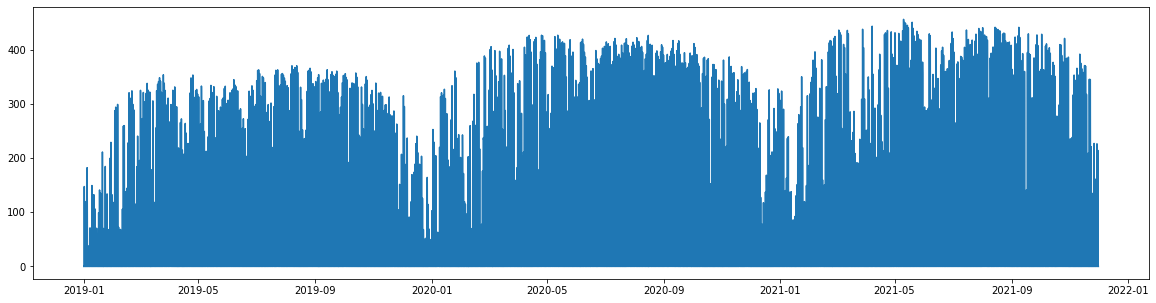

In [6]:
plt.figure(figsize=(20,5))
plt.plot(df['Generation'])
plt.show()

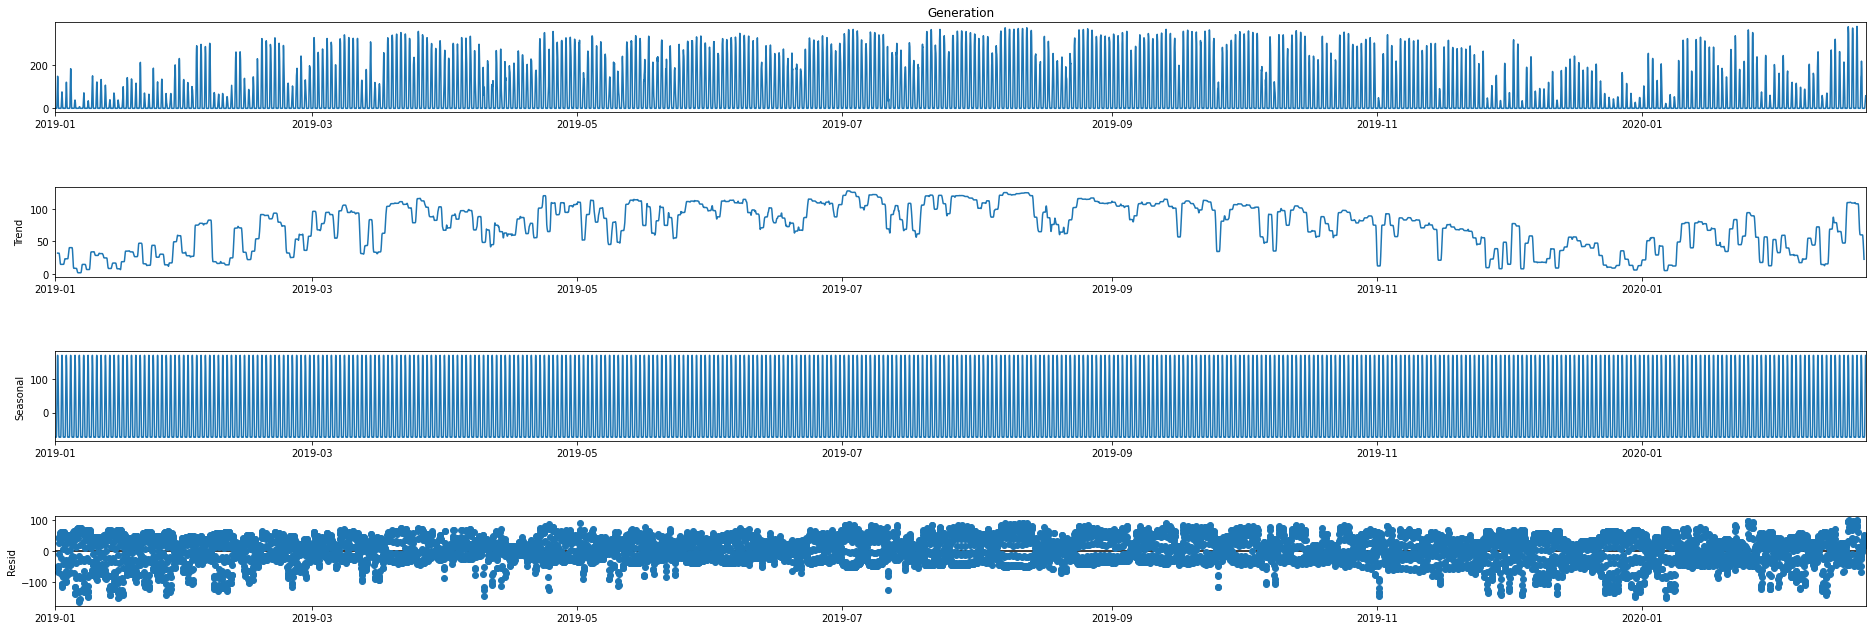

In [7]:
decomposition = sm.tsa.seasonal_decompose(df["Generation"][:10000], period=24)
fig = decomposition.plot()
fig.set_figwidth(30)
fig.set_figheight(10)

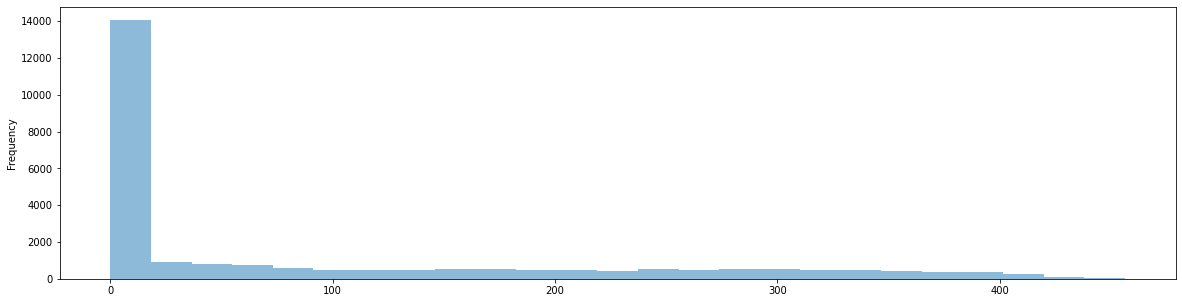

In [8]:
plt.figure(figsize=(20,5))
df['Generation'].plot.hist(bins=25, alpha=0.5)
plt.show()

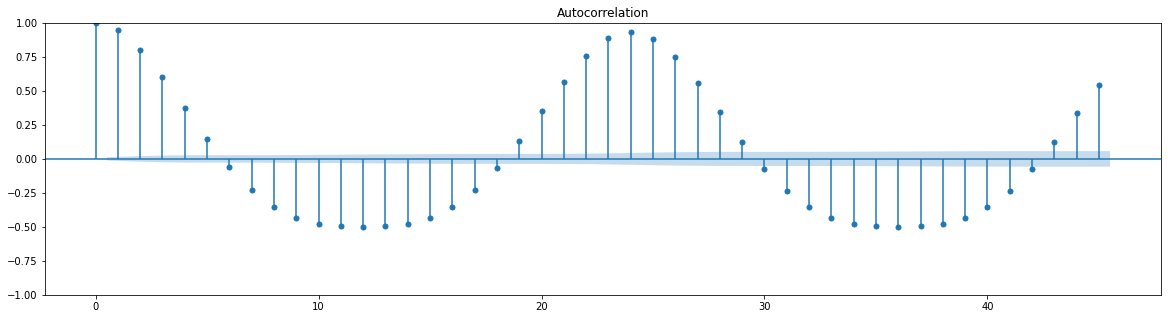

In [9]:
fig = plot_acf(df['Generation']);
fig.set_figwidth(20)
fig.set_figheight(5)

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


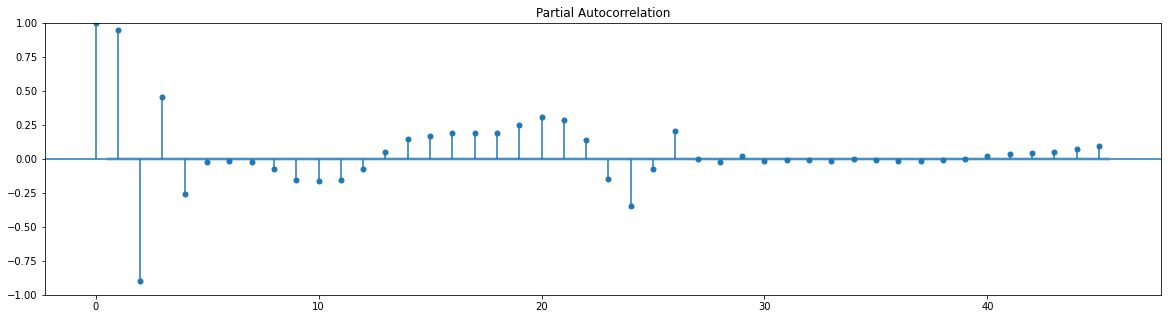

In [10]:
fig = plot_pacf(df['Generation']);
fig.set_figwidth(20)
fig.set_figheight(5)

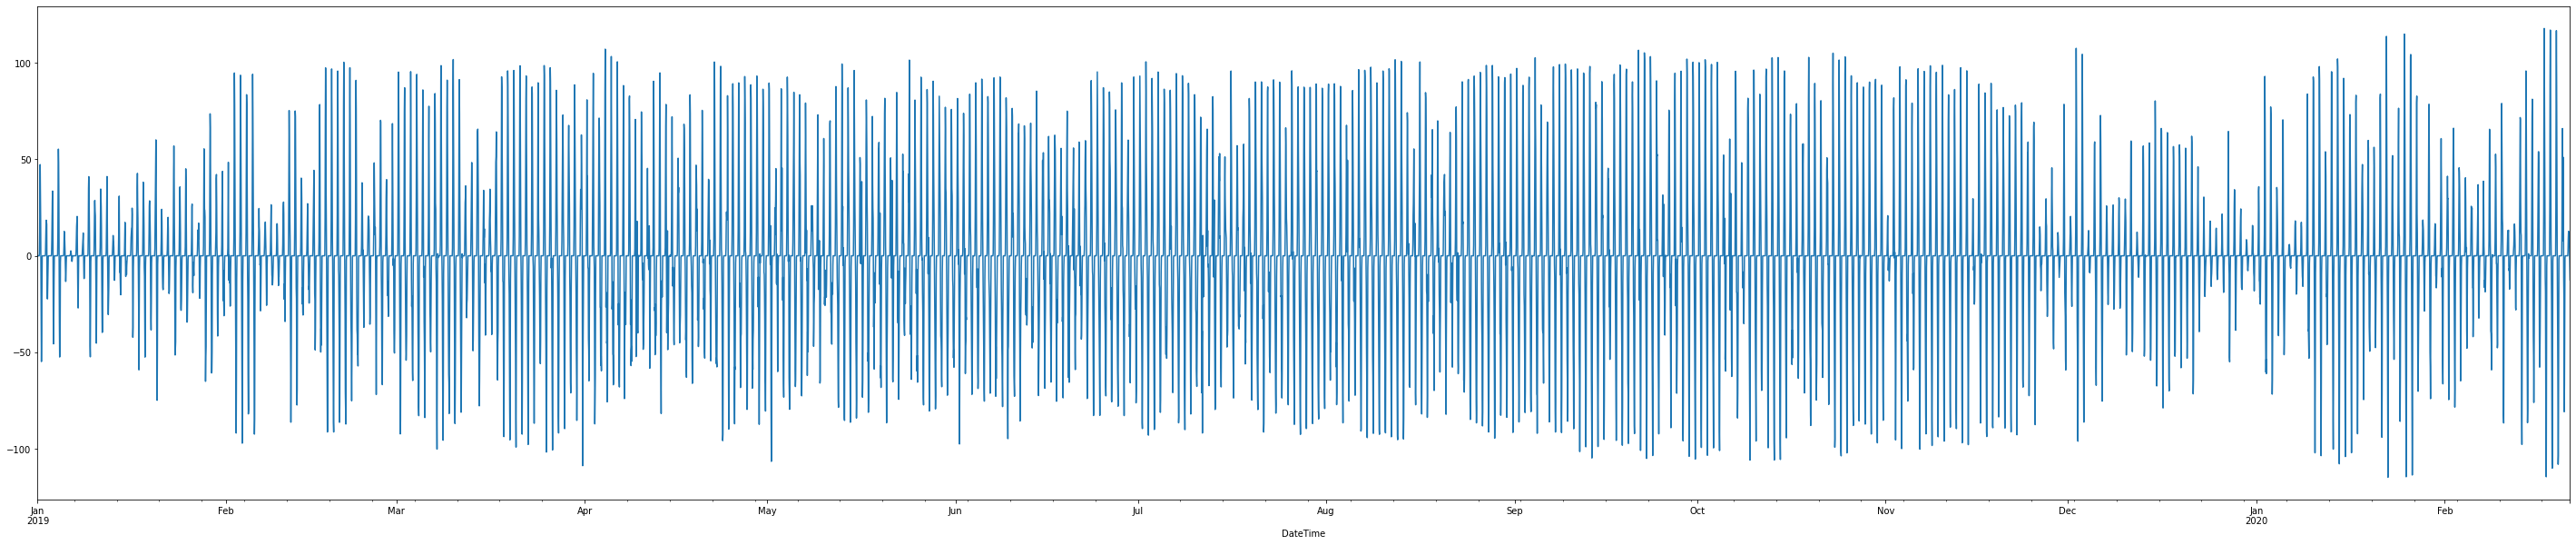

In [11]:
diff = df['Generation'].diff()
plt.figure(figsize=(50,10))
diff[:10000].plot()
plt.show()

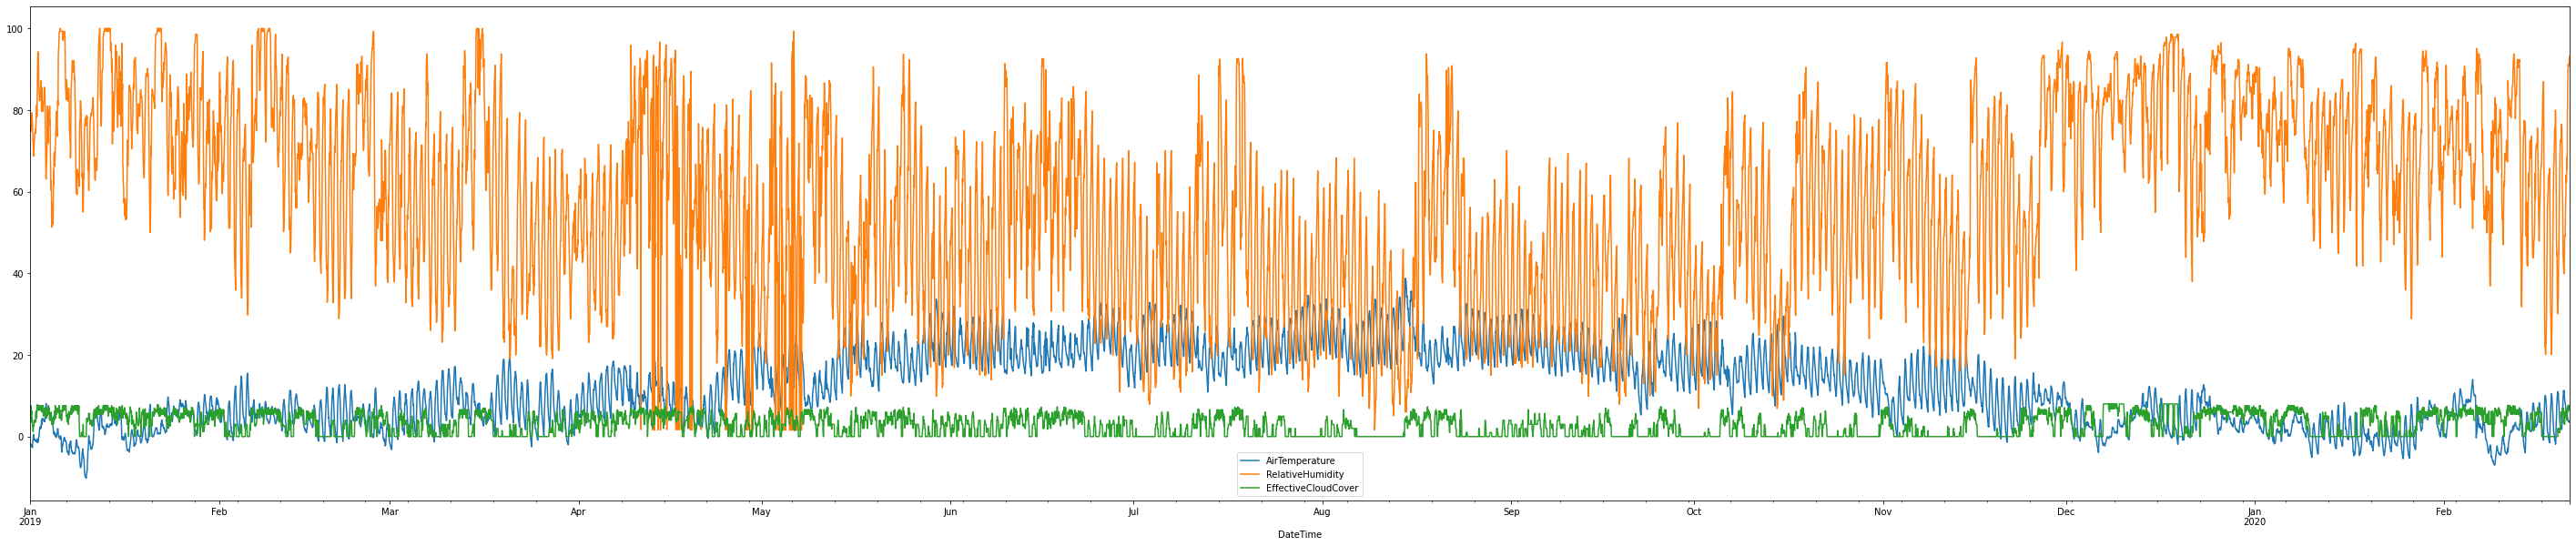

In [12]:
plt.figure(figsize=(50,10))
df['AirTemperature'][:10000].plot()
df['RelativeHumidity'][:10000].plot()
df['EffectiveCloudCover'][:10000].plot()
plt.legend(['AirTemperature', 'RelativeHumidity', 'EffectiveCloudCover'])
plt.show()

<a id="Preparing Data For Modelling"></a>
<center> <h1>Preparing Data For Modelling</h1> </center>


In [13]:
split_date = '2021-05-01'
train = df.loc[df.index <= split_date].copy()
val = df.loc[df.index > split_date].copy()

In [14]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df_copy = df.copy()
    df_copy['date'] = df_copy.index
    df_copy['hour'] = df_copy['date'].dt.hour
    df_copy['dayofweek'] = df_copy['date'].dt.dayofweek
    df_copy['quarter'] = df_copy['date'].dt.quarter
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['dayofyear'] = df_copy['date'].dt.dayofyear
    df_copy['dayofmonth'] = df_copy['date'].dt.day
    df_copy['weekofyear'] = df_copy['date'].dt.weekofyear
    
    X = df_copy[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_copy[label]
        return X, y
    return X

In [15]:
x_train, y_train = create_features(train, label='Generation')
x_val, y_val = create_features(val, label='Generation')
x_test = create_features(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [16]:
x_train = pd.concat([x_train, train.drop('Generation', axis=1)], axis=1)
x_val = pd.concat([x_val, val.drop('Generation', axis=1)], axis=1)
x_test = pd.concat([x_test, test], axis=1)

<a id="XGBoost"></a>
<center> <h1>XGBoost</h1> </center>


In [17]:
model = XGBRegressor(
    random_state=42,
    tree_method="gpu_hist",
    gpu_id=0,
    predictor="gpu_predictor",
    n_estimators=5000,
)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=2,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [18]:
pred_val = model.predict(x_val)
pred_val = pd.DataFrame(pred_val, index=x_val.index, columns=['pred'])

#### Simple trick: Negative predicted and night values are clipped to 0

In [19]:
nights = [21, 22 , 23 , 0, 1, 2, 3, 4]
for row in pred_val.iterrows():
    if row[0].hour in nights or row[1]['pred'] < 0:
        row[1]['pred'] = 0

#### Comparing predictions

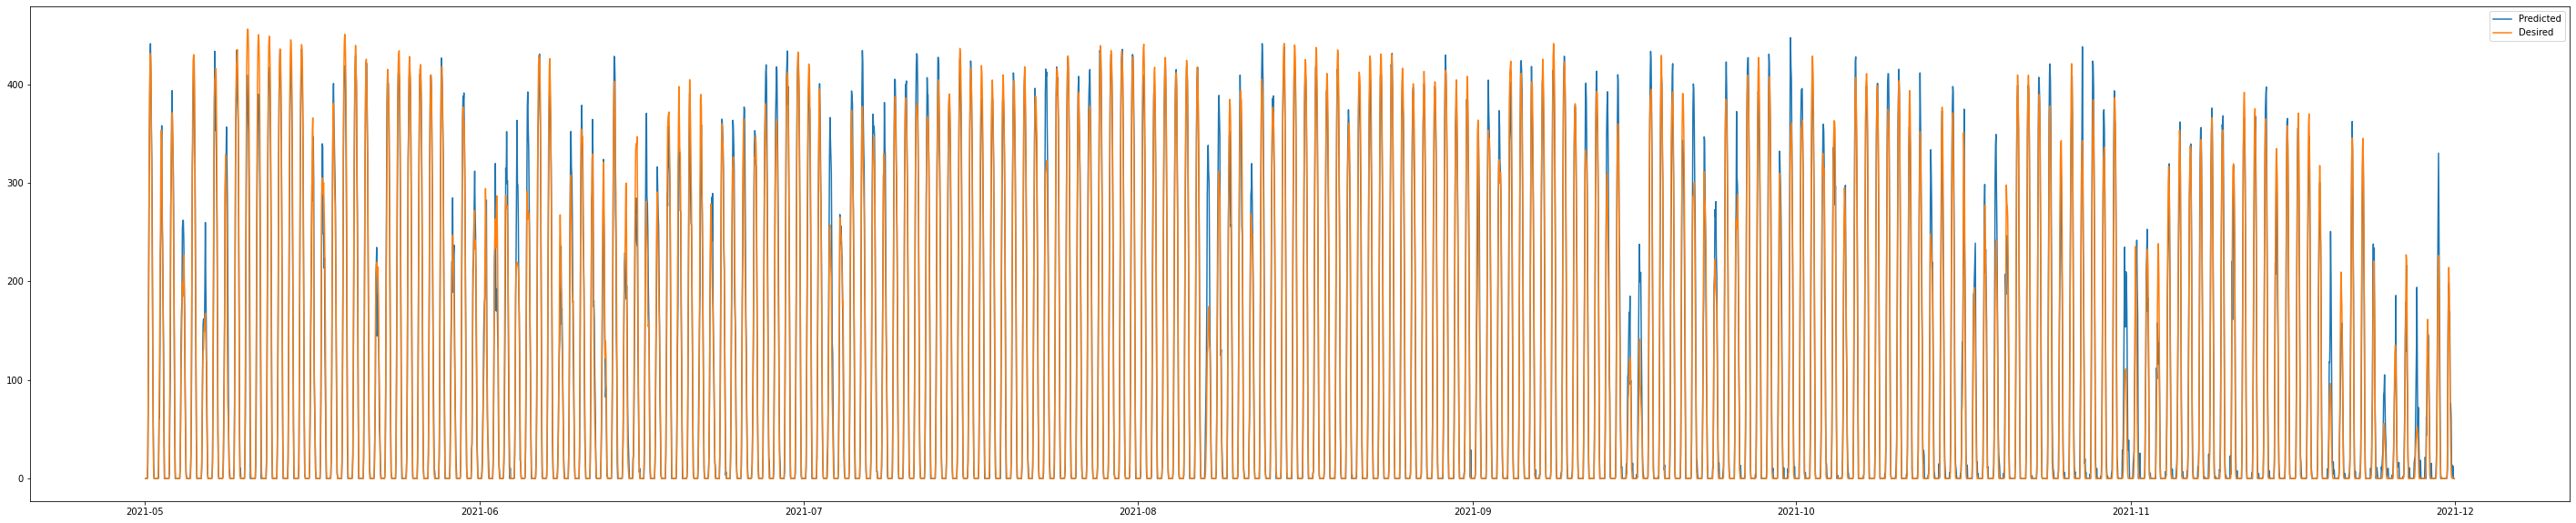

In [20]:
plt.figure(figsize=(50,10))
plt.plot(pred_val)
plt.plot(y_val)
plt.legend(['Predicted', 'Desired'])
plt.show()

In [21]:
print('RMSE: ', mean_squared_error(y_val, pred_val, squared=False))

RMSE:  23.80148575783262


<a id="Exploring Predictions"></a>
<center> <h1>Exploring Predictions</h1> </center>

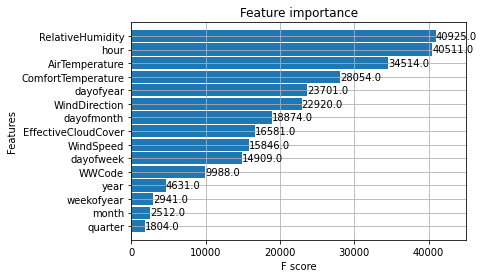

In [22]:
from xgboost import plot_importance
_ = plot_importance(model, height=0.9)

##### Best and worst predicted days, to be honest I didn't get any valuable information from here.

In [23]:
x_val['pred'] = pred_val['pred']
x_val['Generation'] = val['Generation']
x_val['error'] = x_val['Generation'] - pred_val['pred']
x_val['abs_error'] = x_val['error'].apply(np.abs)
error_by_day = x_val.groupby(['year','month','dayofmonth']) \
    .mean()[['Generation','pred','error','abs_error']]

In [24]:
error_by_day.sort_values('error', ascending=True).head(10)

Generation         pred        error   abs_error
year month dayofmonth                                                   
2021 8     7           55.14204249 105.39125824 -50.24921460 50.26680810
     10    31          29.50952978  72.73043823 -43.22090568 43.22090568
     7     3           80.07895092 117.14402771 -37.06507512 37.07390020
     9     16          34.53528693  68.49401855 -33.95873230 33.95873230
     11    19          21.10286799  48.36676025 -27.26389330 27.27557755
     10    19          64.38851890  91.14938354 -26.76086648 26.88894925
     9     21          94.41417856 119.16521454 -24.75103741 25.56805457
     7     23         118.14289825 141.47555542 -23.33266238 24.46825725
     11    27          12.59431707  35.10133362 -22.50701667 22.50701667
           1           46.41224273  68.12064362 -21.70840255 27.37144765

In [25]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

Generation         pred       error  abs_error
year month dayofmonth                                                 
2021 8     3          144.35398910 142.69058228  1.66340127 3.32821067
     7     30         147.45412032 148.05506897 -0.60094684 3.83297673
           29         150.03067203 147.09257507  2.93810056 3.91369628
     10    10         116.78978503 118.46762085 -1.67783677 4.01794555
           22         116.53328224 114.35742188  2.17586137 4.03943766
     11    15          91.14074672  89.17127228  1.96947476 4.29382905
     8     29         135.08919953 134.04756165  1.04163447 4.32200436
           28         131.50349107 128.75679016  2.74669690 4.50936855
     9     10         116.75002408 118.83281708 -2.08279077 4.55649056
     10    8          119.49770804 116.47622681  3.02147800 4.62074840

<a id="Test Predictions"></a>
<center> <h1>Test Predictions</h1> </center>


In [26]:
pred_test = model.predict(x_test)

In [27]:
submission = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/sample_submission.csv')
submission['Generation'] = pred_test

In [28]:
submission.loc[submission['Generation'] < 0, 'Generation'] = 0

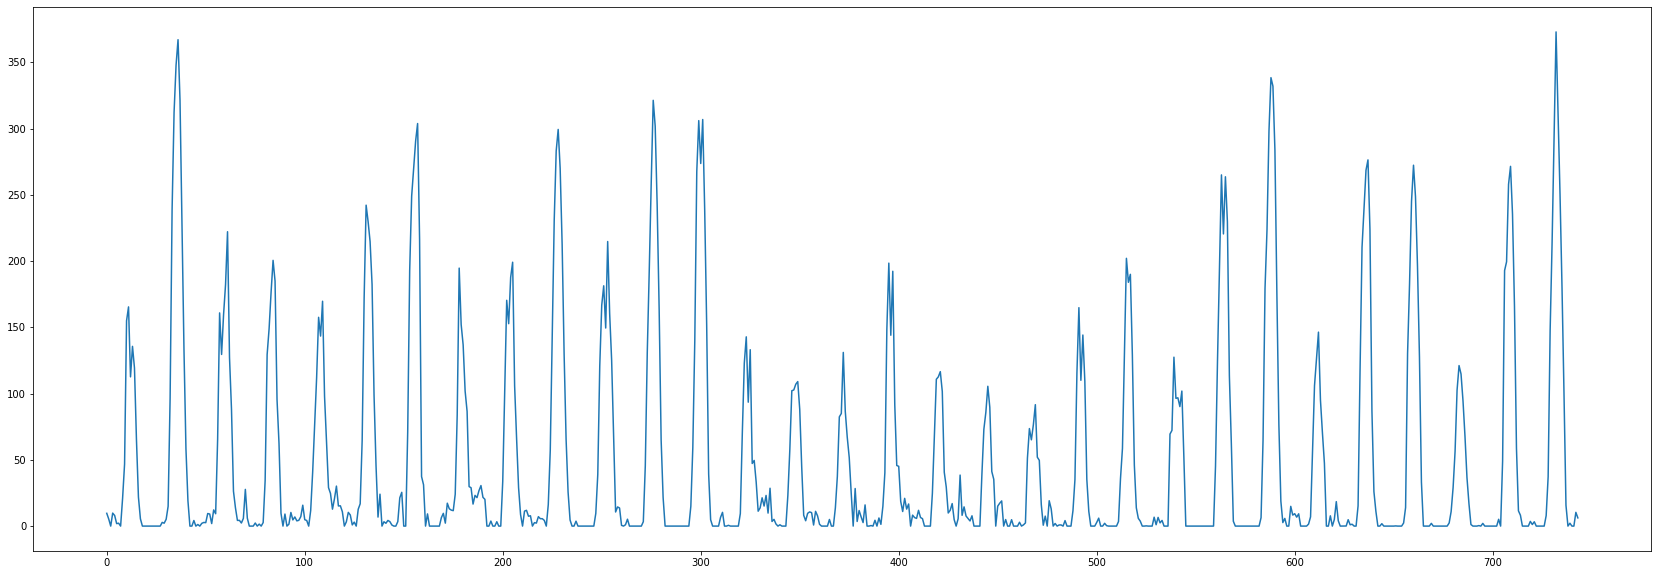

In [29]:
plt.figure(figsize=(29,10))
plt.plot(submission['Generation'])
plt.show()

In [30]:
submission.to_csv('submission.csv', index=False)

<a id="References"></a>
<center> <h1>References</h1> </center>

[TS-0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics#Patterns)

[[Tutorial] Time Series forecasting with XGBoost](https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost/notebook)